In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def f_true(x):
    return 0.03 * x ** 4 - 0.4 * x ** 2 + 0.7 * np.sin(2.2 * x)

def make_poly_features(x, degree):
    x = np.asarray(x).reshape(-1, 1)
    X = np.hstack([x ** i for i in range(degree + 1)])
    return X

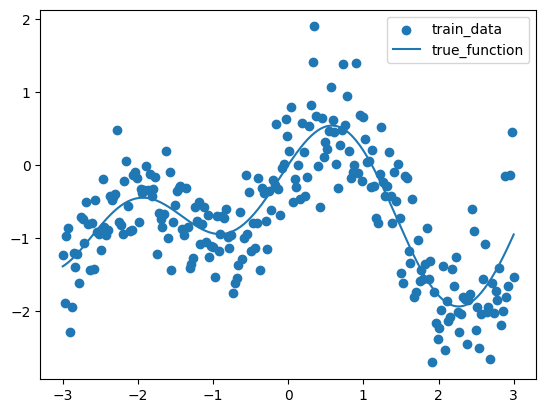

In [3]:
rng = np.random.default_rng(42)

N = 250
x = np.linspace(-3, 3, N)

sigma = 0.5
y = f_true(x) + rng.normal(0, sigma, size=x.shape)

degree = 15
X = make_poly_features(x, degree)

plt.scatter(x, y, label='train_data')
plt.plot(x, f_true(x), label='true_function')
plt.legend()
plt.show()

In [4]:
lamb = 1.0
alpha = 1.0 / (sigma ** 2)

M = X.shape[1]
posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)

In [5]:
posterior_cov = np.linalg.inv(posterior_cov_inv)
mean = alpha * posterior_cov @ (X.T @ y)

In [6]:
x_new = np.linspace(-3, 3, 400)
X_new = make_poly_features(x_new, degree)

mean_pred = X_new @ mean
var_pred = 1.0 / alpha + np.sum(X_new @ posterior_cov @ X_new.T, axis=1)
std_pred = np.sqrt(var_pred)

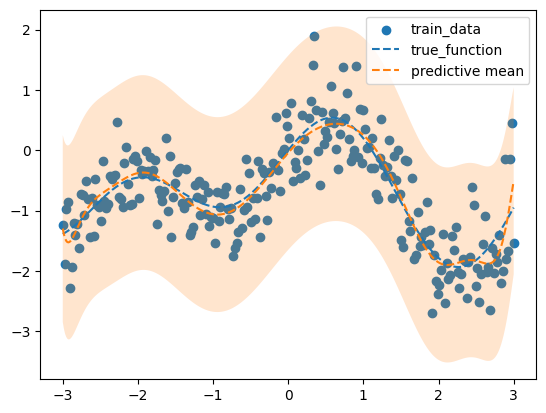

In [7]:
plt.scatter(x, y, label='train_data')
plt.plot(x_new, f_true(x_new), linestyle='--', label='true_function')
plt.plot(x_new, mean_pred, linestyle='--', label='predictive mean')

plt.fill_between(x_new, mean_pred - 2 * std_pred, mean_pred + 2 * std_pred, alpha=0.2)

plt.legend()
plt.show()

In [8]:
def log_evidence(lamb, X, y, alpha):
    '''
    Тут надо написать расчет log-evidence, через формулу, которая была в лекции
    Далее взять какой-то набор лямбд (например np.logspace(-6, 3, 160)) и оценить для каждой эту функцию
    Получится лучшая лябмда
    Вывести график log-evidence vs lambda + графики, чтобы визуально сравнить предсказания базовой модели и модели с лучшей лямбдой
    '''
    N, M = X.shape

    posterior_cov_inv = lamb * np.eye(M) + alpha * (X.T @ X)
    posterior_cov = np.linalg.inv(posterior_cov_inv)
    mean = alpha * posterior_cov @ (X.T @ y)

    sign1, logdet_posterior = np.linalg.slogdet(posterior_cov_inv)
    sign2, logdet_prior = np.linalg.slogdet(lamb * np.eye(M))

    term1 = -N / 2 * np.log(2 * np.pi)
    term2 = N / 2 * np.log(alpha)
    term3 = -alpha / 2 * np.sum(y ** 2)
    term4 = M / 2 * np.log(lamb)
    term5 = -0.5 * logdet_posterior
    term6 = alpha**2 / 2 * mean.T @ (X.T @ X) @ mean

    log_ev = term1 + term2 + term3 + term4 + term5 + term6

    return log_ev

Находим оптимальную λ

In [9]:
lambdas = np.logspace(-6, 3, 160)
log_evidences = []

for lamb in lambdas:
    log_ev = log_evidence(lamb, X, y, alpha)
    log_evidences.append(log_ev)

log_evidences = np.array(log_evidences)

best_idx = np.argmax(log_evidences)
best_lambda = lambdas[best_idx]

print(f"Оптимальная lambda: {best_lambda:.6f}")
print(f"Максимальное log-evidence: {log_evidences[best_idx]:.2f}")

Оптимальная lambda: 0.457486
Максимальное log-evidence: 1291.86


График log-evidence vs lambda

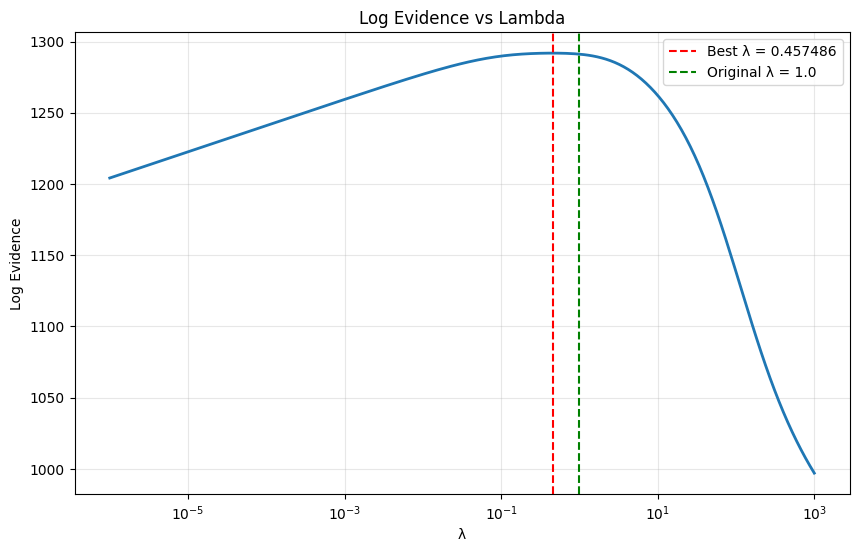

In [10]:
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, log_evidences, linewidth=2)
plt.axvline(best_lambda, color='r', linestyle='--', label=f'Best λ = {best_lambda:.6f}')
plt.axvline(1.0, color='g', linestyle='--', label='Original λ = 1.0')
plt.xlabel('λ')
plt.ylabel('Log Evidence')
plt.title('Log Evidence vs Lambda')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

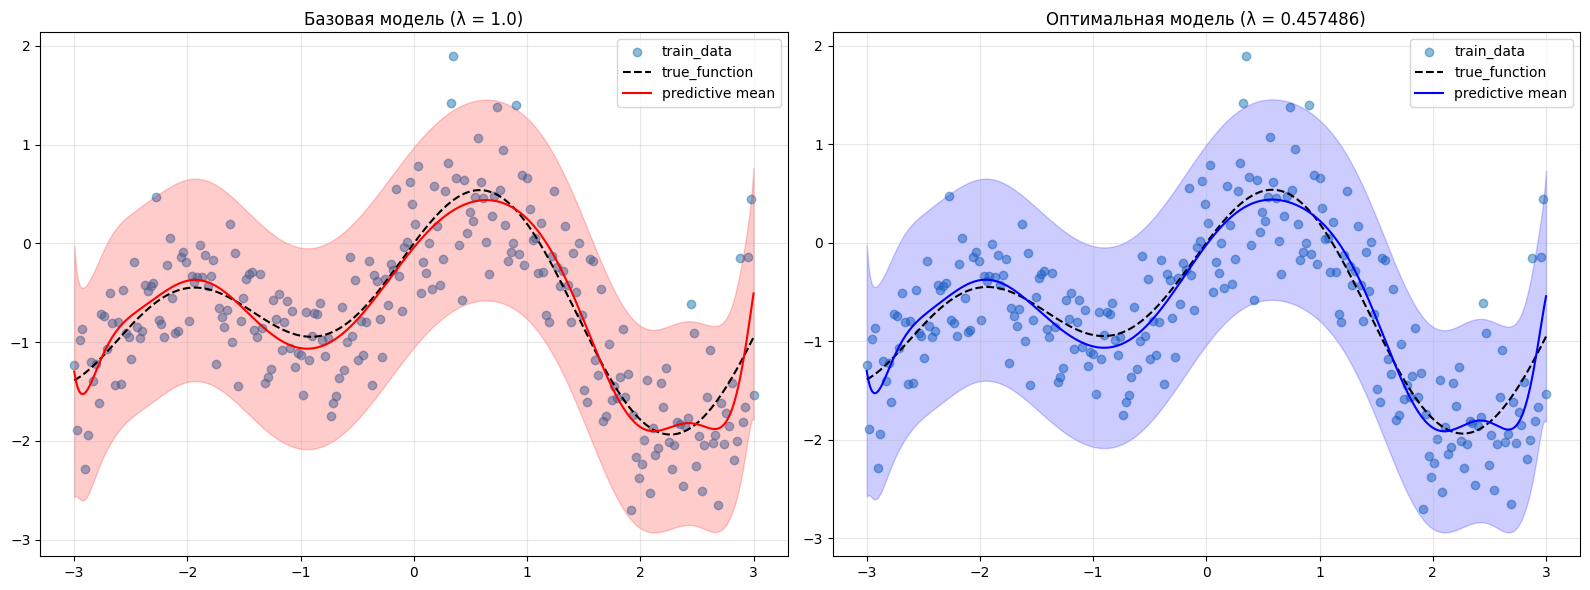

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Базовая модель (λ = 1.0)
lamb_base = 1.0
posterior_cov_inv_base = lamb_base * np.eye(M) + alpha * (X.T @ X)
posterior_cov_base = np.linalg.inv(posterior_cov_inv_base)
mean_base = alpha * posterior_cov_base @ (X.T @ y)
mean_pred_base = X_new @ mean_base
var_pred_base = 1.0 / alpha + np.sum(X_new @ posterior_cov_base * X_new, axis=1)
std_pred_base = np.sqrt(var_pred_base)

axes[0].scatter(x, y, alpha=0.5, label='train_data')
axes[0].plot(x_new, f_true(x_new), 'k--', label='true_function')
axes[0].plot(x_new, mean_pred_base, 'r-', label='predictive mean')
axes[0].fill_between(x_new, mean_pred_base - 2 * std_pred_base,
                      mean_pred_base + 2 * std_pred_base, alpha=0.2, color='red')
axes[0].set_title(f'Базовая модель (λ = {lamb_base})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Оптимальная модель
posterior_cov_inv_opt = best_lambda * np.eye(M) + alpha * (X.T @ X)
posterior_cov_opt = np.linalg.inv(posterior_cov_inv_opt)
mean_opt = alpha * posterior_cov_opt @ (X.T @ y)
mean_pred_opt = X_new @ mean_opt
var_pred_opt = 1.0 / alpha + np.sum(X_new @ posterior_cov_opt * X_new, axis=1)
std_pred_opt = np.sqrt(var_pred_opt)

axes[1].scatter(x, y, alpha=0.5, label='train_data')
axes[1].plot(x_new, f_true(x_new), 'k--', label='true_function')
axes[1].plot(x_new, mean_pred_opt, 'b-', label='predictive mean')
axes[1].fill_between(x_new, mean_pred_opt - 2 * std_pred_opt,
                      mean_pred_opt + 2 * std_pred_opt, alpha=0.2, color='blue')
axes[1].set_title(f'Оптимальная модель (λ = {best_lambda:.6f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Сравнение моделей

In [13]:
mse_base = np.mean((f_true(x_new) - mean_pred_base) ** 2)
mse_opt = np.mean((f_true(x_new) - mean_pred_opt) ** 2)

print(f"MSE базовой модели (λ=1.0): {mse_base:.6f}")
print(f"MSE оптимальной модели (λ={best_lambda:.6f}): {mse_opt:.6f}")
print(f"Улучшение: {(mse_base - mse_opt) / mse_base * 100:.2f}%")


Сравнение моделей:
MSE базовой модели (λ=1.0): 0.011366
MSE оптимальной модели (λ=0.457486): 0.011632
Улучшение: -2.34%
